In [2]:

from sklearn.model_selection import train_test_split
import pandas as pd
#set verbose to 0 so that it prints from the callback function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D


In [3]:
#load data

print('Loading data...')

#4 datasets
#CYP1A2_fixpka.smi
#CYP2C19_substrate_fixpka.smi
#CYP2D6_fixpka.smi
#CYP3A4_fixpka.smi

datasetFile='CYP1A2_fixpka.smi'
dataset = pd.read_csv(datasetFile, sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:            
            char_lib.append(letter)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    
print('data loaded')

Loading data...
data loaded


In [41]:
#add zeros
X=sequence.pad_sequences(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=428)

max_features = len(char_lib)
maxlen = X_train.shape[1]

In [5]:
print(X_train.shape)
print(max_features)
print(maxlen)

(11922, 226)
43
226


In [6]:
import numpy as np
from keras.callbacks import Callback
class CustomCallbacks(Callback):
    def __init__(self, filename="best_weight.hdf5", monitor='val_acc', patience=10):
        super(Callback, self).__init__()
        self.filename = filename
        self.monitor = monitor
        self.patience = patience

        self.wait = 0
        
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.Inf
        self.losses = []
        self.acc = []
        self.val_acc =[]
        self.val_losses=[]             

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))   
        print("acc: %0.3f" % logs.get('acc'), 
              ", loss: %0.3f" % logs.get('loss'),
              ", val_acc: %0.3f" % logs.get('val_acc'),
              ", val_loss: %0.3f" % logs.get('val_loss'))        
        
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
        else:
            if self.monitor_op(current, self.best):
                print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, self.filename))
                self.best = current                       
                self.wait = 0
                self.model.save(self.filename, overwrite=True)
            else:
                print('Epoch %05d: %s did not improve' %  (epoch, self.monitor))
                if self.wait >= self.patience:                   
                    self.model.stop_training = True
                self.wait += 1

    def on_train_end(self, logs=None):
        if self.wait >= self.patience:
            print('Warning: early stopping')
        self.wait=0
        if 'acc' in self.monitor or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.In
        
my_callbacks=CustomCallbacks(filename="CYP1A2_conv1.hdf5", monitor='val_acc', patience=np.Inf)


In [15]:
from keras.layers.pooling import MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.recurrent import LSTM 
from keras.layers import Flatten

In [57]:
model = Sequential()
model.add(Embedding(input_dim=max_features,output_dim=50, input_length=maxlen))
model.add(Dropout(0.5))

model.add(Conv1D(filters=500,kernel_size=7, padding='valid', strides=1))
model.add(LeakyReLU(0.3)) #better than relu with 0.004 more accuracy...
model.add(GlobalMaxPooling1D())
#model.add(MaxPooling1D(pool_size=2))


model.add(Dense(250))
model.add(Dropout(0.5))
model.add(LeakyReLU(0.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 226, 50)           2150      
_________________________________________________________________
dropout_58 (Dropout)         (None, 226, 50)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 220, 500)          175500    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 220, 500)          0         
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 500)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_59 (Dropout)         (None, 250)               0         
__________

In [ ]:
#data is not shuffled using validation_split. Have to use sk-learn to shuffle it first. 
model.fit(X_train, y_train,
          batch_size=100,
          epochs=100,
          callbacks=[my_callbacks],
          validation_split=0.2,
          verbose=0) 

acc: 0.691 , loss: 0.582 , val_acc: 0.747 , val_loss: 0.524
Epoch 00000: val_acc improved from -inf to 0.74675, saving model to CYP1A2_conv1.hdf5
acc: 0.745 , loss: 0.520 , val_acc: 0.740 , val_loss: 0.522
Epoch 00001: val_acc did not improve
acc: 0.759 , loss: 0.502 , val_acc: 0.769 , val_loss: 0.496
Epoch 00002: val_acc improved from 0.74675 to 0.76855, saving model to CYP1A2_conv1.hdf5
acc: 0.763 , loss: 0.496 , val_acc: 0.769 , val_loss: 0.505
Epoch 00003: val_acc improved from 0.76855 to 0.76897, saving model to CYP1A2_conv1.hdf5
acc: 0.771 , loss: 0.482 , val_acc: 0.785 , val_loss: 0.478
Epoch 00004: val_acc improved from 0.76897 to 0.78532, saving model to CYP1A2_conv1.hdf5
acc: 0.781 , loss: 0.471 , val_acc: 0.790 , val_loss: 0.473
Epoch 00005: val_acc improved from 0.78532 to 0.79036, saving model to CYP1A2_conv1.hdf5
acc: 0.783 , loss: 0.462 , val_acc: 0.788 , val_loss: 0.486
Epoch 00006: val_acc did not improve
acc: 0.784 , loss: 0.461 , val_acc: 0.791 , val_loss: 0.476
Epoc

acc: 0.887 , loss: 0.264 , val_acc: 0.799 , val_loss: 0.568
Epoch 00076: val_acc did not improve
acc: 0.895 , loss: 0.257 , val_acc: 0.805 , val_loss: 0.527
Epoch 00077: val_acc did not improve
acc: 0.890 , loss: 0.261 , val_acc: 0.797 , val_loss: 0.593
Epoch 00078: val_acc did not improve
acc: 0.889 , loss: 0.258 , val_acc: 0.806 , val_loss: 0.553
Epoch 00079: val_acc did not improve
acc: 0.891 , loss: 0.261 , val_acc: 0.799 , val_loss: 0.536
Epoch 00080: val_acc did not improve
acc: 0.893 , loss: 0.259 , val_acc: 0.806 , val_loss: 0.533
Epoch 00081: val_acc did not improve
acc: 0.893 , loss: 0.257 , val_acc: 0.805 , val_loss: 0.566
Epoch 00082: val_acc did not improve
acc: 0.887 , loss: 0.270 , val_acc: 0.795 , val_loss: 0.556
Epoch 00083: val_acc did not improve
acc: 0.891 , loss: 0.258 , val_acc: 0.798 , val_loss: 0.554
Epoch 00084: val_acc did not improve
acc: 0.894 , loss: 0.257 , val_acc: 0.789 , val_loss: 0.548
Epoch 00085: val_acc did not improve
acc: 0.889 , loss: 0.257 , val

In [24]:
from keras import models
best_model=models.load_model("CYP1A2_conv1_valacc820_testacc808auc883.hdf5")
print(best_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 226, 50)           2150      
_________________________________________________________________
dropout_6 (Dropout)          (None, 226, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 220, 500)          175500    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 220, 500)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 220, 500)          0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
__________

2688/2981 [==========================>...] - ETA: 0s

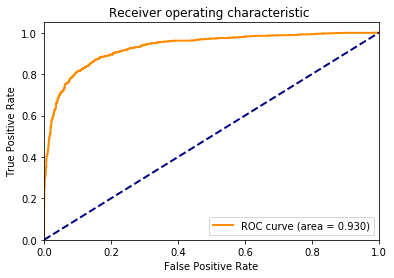

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_score=model.predict_proba(X_test)
y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.savefig("roc.svg", format="svg")
plt.show()


